In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/etc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13428005538215583737
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14444669198598367767
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12044523677215764905
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15858476647
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15035141666758928001
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 6.0"
]


In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from data import *
from model import *
from utilities import *
from keras.callbacks import ModelCheckpoint, TensorBoard

train on VGG from scratch

In [3]:
TRAIN = True 
scale = 1
batch_size = 4
epochs = 100
vgg_num_train = int(0.8*200)
vgg_num_val = int(0.1*200)
vgg_num_test = int(0.1*200)

load VGG dataset

In [5]:
datasetfilename = "sq-cell2-dataset.p"

img_file_path = []
for filename in glob.iglob('cells/*cell.png'):
    xml = filename.split("cell.png")[0] + "dots.png"
    img_file_path.append([filename, xml])

# load data
np_dataset_x, np_dataset_y, np_dataset_c = data_process(datasetfilename, img_file_path, verbose = False)

reading from preprocessed data:  sq-cell2-dataset.p
image data shape:  (200, 256, 256, 1)
ground truth data shape (200, 288, 288, 1)
count data shape (200, 1)


shuffle the data if needed.

In [7]:
indices = np.arange(np_dataset_x.shape[0])
np.random.shuffle(indices)
np_dataset_x = np_dataset_x[indices]
np_dataset_y = np_dataset_y[indices]
np_dataset_c = np_dataset_c[indices]

train-val-test split (8:1:1)

In [6]:
# split train-val-test
np_dataset_x_train = np_dataset_x[:vgg_num_train]
np_dataset_y_train = np_dataset_y[:vgg_num_train]
np_dataset_c_train = np_dataset_c[:vgg_num_train]

np_dataset_x_valid = np_dataset_x[vgg_num_train:vgg_num_train+vgg_num_val]
np_dataset_y_valid = np_dataset_y[vgg_num_train:vgg_num_train+vgg_num_val]
np_dataset_c_valid = np_dataset_c[vgg_num_train:vgg_num_train+vgg_num_val]

np_dataset_x_test = np_dataset_x[vgg_num_train+vgg_num_val:]
np_dataset_y_test = np_dataset_y[vgg_num_train+vgg_num_val:]
np_dataset_c_test = np_dataset_c[vgg_num_train+vgg_num_val:]

build model

In [7]:
model = build_model(train_conv=TRAIN)

bestcheck = ModelCheckpoint(filepath="best-models-3/model-best.h5", verbose=1, save_weights_only=True, save_best_only=True)
every10check = ModelCheckpoint(filepath="models-3/model-cp.{epoch:02d}-{val_loss:.2f}.h5", verbose=1, period=10, save_weights_only=True)
tbCallBack = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

hist = model.fit(np_dataset_x_train, np_dataset_y_train, epochs=epochs, batch_size = batch_size,
                    validation_data = (np_dataset_x_valid, np_dataset_y_valid), 
                    callbacks=[bestcheck, every10check, tbCallBack])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
adapterIadaper_bn1 (BatchNormal (None, 256, 256, 1)  4           input_2[0][0]                    
__________________________________________________________________________________________________
adapterIadapter_conv (Conv2D)   (None, 256, 256, 1)  2           adapterIadaper_bn1[0][0]         
__________________________________________________________________________________________________
add_5 (Add)                     (None, 256, 256, 1)  0           adapterIadapter_conv[0][0]       
                                                                 input_2[0][0]                    
__________

Train on 160 samples, validate on 20 samples
Epoch 1/100
160/160 [==============================] - 33s 203ms/step - loss: 2.1761 - acc: 0.2395 - val_loss: 1.3619 - val_acc: 0.3570

Epoch 00001: val_loss improved from inf to 1.36190, saving model to best-models-3/model-best.h5
Epoch 2/100
160/160 [==============================] - 28s 175ms/step - loss: 2.1254 - acc: 0.2503 - val_loss: 1.5638 - val_acc: 0.2812

Epoch 00002: val_loss did not improve from 1.36190
Epoch 3/100
160/160 [==============================] - 28s 175ms/step - loss: 2.0846 - acc: 0.2495 - val_loss: 1.6977 - val_acc: 0.2589

Epoch 00003: val_loss did not improve from 1.36190
Epoch 4/100
160/160 [==============================] - 28s 175ms/step - loss: 2.0443 - acc: 0.2491 - val_loss: 1.7942 - val_acc: 0.2501

Epoch 00004: val_loss did not improve from 1.36190
Epoch 5/100
160/160 [==============================] - 28s 175ms/step - loss: 2.0040 - acc: 0.2488 - val_loss: 1.8467 - val_acc: 0.2479

Epoch 00005: val_loss

160/160 [==============================] - 28s 174ms/step - loss: 0.3537 - acc: 0.7534 - val_loss: 0.2086 - val_acc: 0.8452

Epoch 00079: val_loss did not improve from 0.20655
Epoch 80/100
160/160 [==============================] - 28s 174ms/step - loss: 0.3498 - acc: 0.7551 - val_loss: 0.2085 - val_acc: 0.8435

Epoch 00080: val_loss did not improve from 0.20655

Epoch 00080: saving model to models-3/model-cp.80-0.21.h5
Epoch 81/100
160/160 [==============================] - 28s 174ms/step - loss: 0.4133 - acc: 0.7005 - val_loss: 0.2686 - val_acc: 0.7909

Epoch 00081: val_loss did not improve from 0.20655
Epoch 82/100
160/160 [==============================] - 28s 174ms/step - loss: 0.3707 - acc: 0.7386 - val_loss: 0.2178 - val_acc: 0.8292

Epoch 00082: val_loss did not improve from 0.20655
Epoch 83/100
160/160 [==============================] - 28s 174ms/step - loss: 0.3801 - acc: 0.7272 - val_loss: 0.2726 - val_acc: 0.8262

Epoch 00083: val_loss did not improve from 0.20655
Epoch 84/

load the best pre-trained weight by validation.

In [7]:
TRAIN = False
model = build_model(train_conv=TRAIN)
model.load_weights("best-models-3/model-best.h5", by_name=True)
#model.load_weights("models-2/model-cp.100-0.24.h5", by_name=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
adapterIadaper_bn1 (BatchNormal (None, 256, 256, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
adapterIadapter_conv (Conv2D)   (None, 256, 256, 1)  2           adapterIadaper_bn1[0][0]         
__________________________________________________________________________________________________
add_1 (Add)                     (None, 256, 256, 1)  0           adapterIadapter_conv[0][0]       
                                                                 input_1[0][0]                    
__________

test on VGG

In [9]:
pred = model.predict(np_dataset_x_test, batch_size=1)
preds = sum_count_map(pred)
tests = np.concatenate(np_dataset_c_test)
print("Test MSE:", np.mean((preds-tests)**2))
print("Test MAE:", np.mean(np.abs(preds-tests)))

Test MSE: 17.205805556158886
Test MAE: 3.2468753814697267


In [10]:
preds

array([221.69769287, 103.66764069, 108.5962677 , 151.1191864 ,
       156.27622986, 264.2956543 , 193.70843506, 169.72155762,
       178.19906616, 137.38917542,  82.81166077, 244.23736572,
       251.35429382, 115.65097046, 192.41667175, 263.13806152,
       175.10575867, 195.87387085,  83.48453522, 124.72431183])

In [11]:
tests

array([221., 104., 111., 155., 158., 267., 198., 173., 181., 140.,  86.,
       252., 250., 115., 198., 269., 186., 199.,  84., 126.])

In [17]:
print("Test std:", np.std(np.abs(preds-tests)))

Test std: 2.5813960977278754


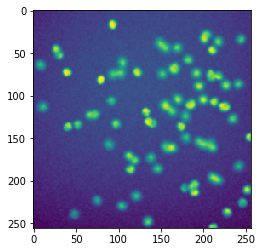

In [14]:
plot_map(np_dataset_x_test[10])

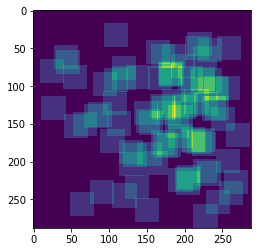

In [16]:
plot_map(np_dataset_y_test[10])

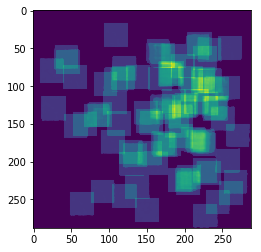

In [15]:
plot_map(pred[10])

adapt to our data. (one shot, rescaled to $256 \times 256$)

load data.

In [75]:
trainfilename = "sq-our_256-train.p"
train_x, train_y, train_c = data_process(trainfilename, [["ours_1024/all/0image.jpg", "ours_1024/all/0dots.jpg"], 
                                                         ["ours_1024/all/1image.jpg", "ours_1024/all/1dots.jpg"], 
                                                         ["ours_1024/all/2image.jpg", "ours_1024/all/2dots.jpg"],
                                                         ["ours_1024/all/3image.jpg", "ours_1024/all/2dots.jpg"],
                                                         ["ours_1024/all/4image.jpg", "ours_1024/all/4dots.jpg"],
                                                         ["ours_1024/all/5image.jpg", "ours_1024/all/5dots.jpg"]],
                                         scale = 4, framesize = 256, slice_stride = 128, kernel = "sq", verbose = True)

reading from preprocessed data:  sq-our_256-train.p
image data shape:  (4, 256, 256, 1)
ground truth data shape (4, 288, 288, 1)
count data shape (4, 1)


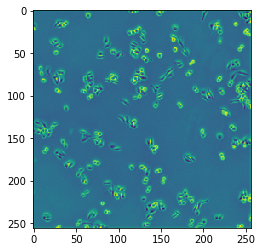

In [76]:
plot_map(train_x[0])

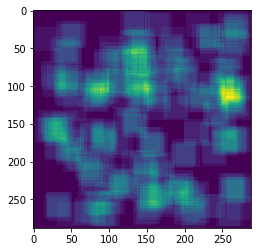

In [77]:
plot_map(train_y[0])

In [78]:
valfilename = "sq-our_256-val.p"
val_x, val_y, val_c = data_process(trainfilename, [["ours_1024/all/6image.jpg", "ours_1024/all/6dots.jpg"], 
                                                         ["ours_1024/all/7image.jpg", "ours_1024/all/7dots.jpg"], 
                                                         ["ours_1024/all/2image.jpg", "ours_1024/all/2dots.jpg"],
                                                         ["ours_1024/all/3image.jpg", "ours_1024/all/2dots.jpg"],
                                                         ["ours_1024/all/4image.jpg", "ours_1024/all/4dots.jpg"],
                                                         ["ours_1024/all/5image.jpg", "ours_1024/all/5dots.jpg"]],
                                         scale = 4, framesize = 256, slice_stride = 128, kernel = "sq", verbose = True)

reading from preprocessed data:  sq-our_256-val.p
image data shape:  (1, 256, 256, 1)
ground truth data shape (1, 288, 288, 1)
count data shape (1, 1)


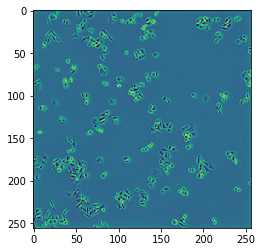

In [79]:
plot_map(val_x[0], "output_img/val_ours.png")

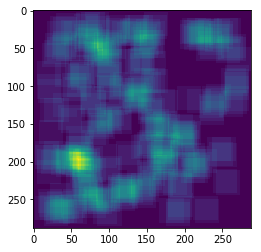

In [80]:
plot_map(val_y[0], "output_img/val_ours.png")

In [81]:
testfilename = "sq-our_256-test.p"
test_x, test_y, test_c = data_process(testfilename, [['ours_256/1image.jpg', 'ours_256/1dots.jpg'], 
                                                     ['ours_256/2image.jpg', 'ours_256/2dots.jpg']],
                                      scale = 1, framesize = 256, slice_stride = 128, kernel = "sq", verbose = True)

reading from preprocessed data:  sq-our_256-test.p
image data shape:  (1, 256, 256, 1)
ground truth data shape (1, 288, 288, 1)
count data shape (1, 1)


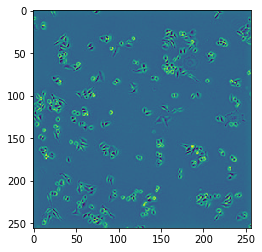

In [82]:
plot_map(test_x[0])

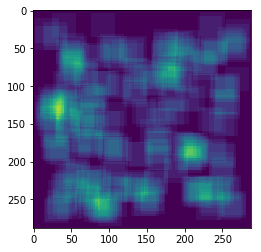

In [83]:
plot_map(test_y[0])

load pre-trained weight.

In [84]:
TRAIN = False
model = build_model(train_conv=TRAIN)
model.load_weights("best-models-3/model-best.h5", by_name=True)
#model.load_weights("models-2/model-cp.100-0.24.h5", by_name=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
adapterIadaper_bn1 (BatchNormal (None, 256, 256, 1)  4           input_11[0][0]                   
__________________________________________________________________________________________________
adapterIadapter_conv (Conv2D)   (None, 256, 256, 1)  2           adapterIadaper_bn1[0][0]         
__________________________________________________________________________________________________
add_50 (Add)                    (None, 256, 256, 1)  0           adapterIadapter_conv[0][0]       
                                                                 input_11[0][0]                   
__________

In [24]:
batch_size = 1
epochs = 100

In [25]:
bestcheck = ModelCheckpoint(filepath="best-models-3/model-best-ours256.h5", verbose=1, save_weights_only=True, save_best_only=True)
every10check = ModelCheckpoint(filepath="models-3/model-ours256-cp.{epoch:02d}-{val_loss:.2f}.h5", verbose=1, period=10, save_weights_only=True)
tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

hist = model.fit(train_x, train_y, epochs=epochs, initial_epoch=0, batch_size = batch_size,
                 validation_data = (val_x, val_y), 
                 callbacks=[bestcheck, every10check, tbCallBack])

Train on 4 samples, validate on 1 samples
Epoch 1/100
4/4 [==============================] - 6s 1s/step - loss: 2.7184 - acc: 0.2200 - val_loss: 3.0085 - val_acc: 0.2327

Epoch 00001: val_loss improved from inf to 3.00853, saving model to best-models-3/model-best-ours256.h5
Epoch 2/100
4/4 [==============================] - 1s 232ms/step - loss: 2.6721 - acc: 0.2252 - val_loss: 2.3875 - val_acc: 0.2623

Epoch 00002: val_loss improved from 3.00853 to 2.38750, saving model to best-models-3/model-best-ours256.h5
Epoch 3/100
4/4 [==============================] - 1s 225ms/step - loss: 2.6521 - acc: 0.2233 - val_loss: 1.8459 - val_acc: 0.3136

Epoch 00003: val_loss improved from 2.38750 to 1.84593, saving model to best-models-3/model-best-ours256.h5
Epoch 4/100
4/4 [==============================] - 1s 222ms/step - loss: 2.6408 - acc: 0.2199 - val_loss: 1.5672 - val_acc: 0.3499

Epoch 00004: val_loss improved from 1.84593 to 1.56719, saving model to best-models-3/model-best-ours256.h5
Epoch

4/4 [==============================] - 1s 222ms/step - loss: 2.4663 - acc: 0.2225 - val_loss: 2.3427 - val_acc: 0.2413

Epoch 00042: val_loss did not improve from 1.40665
Epoch 43/100
4/4 [==============================] - 1s 222ms/step - loss: 2.4620 - acc: 0.2233 - val_loss: 2.3917 - val_acc: 0.2380

Epoch 00043: val_loss did not improve from 1.40665
Epoch 44/100
4/4 [==============================] - 1s 222ms/step - loss: 2.4583 - acc: 0.2236 - val_loss: 2.3232 - val_acc: 0.2443

Epoch 00044: val_loss did not improve from 1.40665
Epoch 45/100
4/4 [==============================] - 1s 220ms/step - loss: 2.4536 - acc: 0.2244 - val_loss: 2.2106 - val_acc: 0.2589

Epoch 00045: val_loss did not improve from 1.40665
Epoch 46/100
4/4 [==============================] - 1s 221ms/step - loss: 2.4500 - acc: 0.2249 - val_loss: 2.1821 - val_acc: 0.2614

Epoch 00046: val_loss did not improve from 1.40665
Epoch 47/100
4/4 [==============================] - 1s 223ms/step - loss: 2.4455 - acc: 0.225

load the best model by validation.

In [88]:
TRAIN = False
model = build_model(train_conv=TRAIN)
model.load_weights("best-models-3/model-best-ours256-2.h5", by_name=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
adapterIadaper_bn1 (BatchNormal (None, 256, 256, 1)  4           input_12[0][0]                   
__________________________________________________________________________________________________
adapterIadapter_conv (Conv2D)   (None, 256, 256, 1)  2           adapterIadaper_bn1[0][0]         
__________________________________________________________________________________________________
add_55 (Add)                    (None, 256, 256, 1)  0           adapterIadapter_conv[0][0]       
                                                                 input_12[0][0]                   
__________

test using our data (size of $256 \times 256$).

In [33]:
# batch size = 1
pred = model.predict(test_x, batch_size=1)
preds = sum_count_map(pred, ef=32*32)
tests = np.concatenate(test_c)
print("Test MSE:", np.mean((preds-tests)**2))
print("Test MAE:", np.mean(np.abs(preds-tests)))

Test MSE: 808.7695140624419
Test MAE: 28.438873291015625


In [42]:
tests

array([335.])

In [41]:
preds

array([363.43887329])

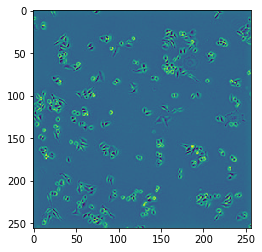

In [35]:
plot_map(test_x[0])

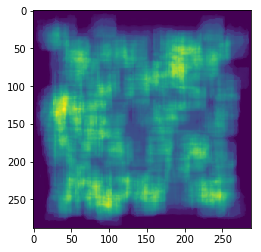

In [36]:
plot_map(pred[0]) # batch size = 1

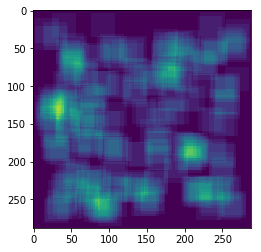

In [31]:
plot_map(test_y[0])

Adapt to our data. (resize to $512 \times 512$, sliced into $256 \times 256$ sub-images with a stride of 128.)

load data:

In [4]:
trainfilename = "sq-our_512_div_sliced-train.p"
x, y, c = data_process(trainfilename, [["ours_1024/dividing/2image.jpg", "ours_1024/dividing/2dots.jpg"], 
                                       ["ours_1024/dividing/3image.jpg", "ours_1024/dividing/3dots.jpg"], 
                                       ["ours_1024/dividing/4image.jpg", "ours_1024/dividing/4dots.jpg"]],
                       scale = 2, framesize = 256, slice_stride = 64, kernel = "sq",
                       slicing = True, verbose = True)

total number of images:  3
input image raw shape (1024, 1024)  ->>>> (512, 512)


/home/xywang/.local/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/xywang/.local/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


count  [40.0] == lab_est [40.0]
(0, 0)
count  [35.0] == lab_est [35.0]
(0, 64)
count  [25.0] == lab_est [25.0]
(0, 128)
count  [23.0] == lab_est [23.0]
(0, 192)
count  [25.0] == lab_est [25.0]
(0, 256)
count  [38.0] == lab_est [38.0]
(64, 0)
count  [35.0] == lab_est [35.0]
(64, 64)
count  [29.0] == lab_est [29.0]
(64, 128)
count  [26.0] == lab_est [26.0]
(64, 192)
count  [27.0] == lab_est [27.0]
(64, 256)
count  [40.0] == lab_est [40.0]
(128, 0)
count  [36.0] == lab_est [36.0]
(128, 64)
count  [32.0] == lab_est [32.0]
(128, 128)
count  [26.0] == lab_est [26.0]
(128, 192)
count  [23.0] == lab_est [23.0]
(128, 256)
count  [32.0] == lab_est [32.0]
(192, 0)
count  [28.0] == lab_est [28.0]
(192, 64)
count  [23.0] == lab_est [23.0]
(192, 128)
count  [19.0] == lab_est [19.0]
(192, 192)
count  [19.0] == lab_est [19.0]
(192, 256)
count  [30.0] == lab_est [30.0]
(256, 0)
count  [29.0] == lab_est [29.0]
(256, 64)
count  [26.0] == lab_est [26.0]
(256, 128)
count  [24.0] == lab_est [24.0]
(256, 192

In [5]:
print ("number of counts total ", c.sum())
print ("number of counts on average ", c.mean(), "+-", c.std())
print ("counts min:", c.min(), "max:", c.max())

number of counts total  1472.0
number of counts on average  19.626666666666665 +- 10.003697094352445
counts min: 4.0 max: 40.0


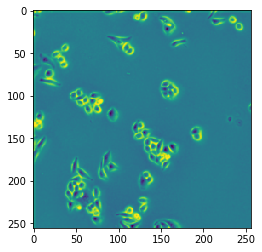

In [6]:
plot_map(x[0])

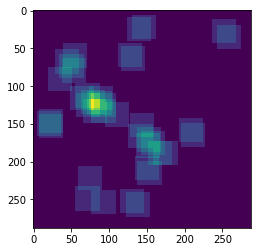

In [7]:
plot_map(y[0])

shuffle indices

In [8]:
indices = np.arange(x.shape[0])
np.random.shuffle(indices)
x = x[indices]
y = y[indices]
c = c[indices]

train-val split

In [9]:
num_train = int(x.shape[0]*0.9)
train_x = x[:num_train]
train_y = y[:num_train]
train_c = c[:num_train]
val_x = x[num_train:]
val_y = y[num_train:]
val_c = c[num_train:]

In [10]:
trainfilename = "sq-our_512_div-5.p"
test_x, test_y, test_c = data_process(trainfilename, [["ours_1024/dividing/5image.jpg", "ours_1024/dividing/5dots.jpg"]],
                                      scale = 2, framesize = 256, slice_stride = 64, kernel = "sq",
                                      verbose = True)

total number of images:  1
input image raw shape (1024, 1024)  ->>>> (512, 512)


/home/xywang/.local/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/xywang/.local/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


count  [18.0] == lab_est [18.0]
(0, 0)
count  [10.0] == lab_est [10.0]
(0, 256)
count  [19.0] == lab_est [19.0]
(256, 0)
count  [7.0] == lab_est [7.0]
(256, 256)
save data to a binary file:  sq-our_512_div-5.p
image data shape:  (4, 256, 256, 1)
ground truth data shape (4, 288, 288, 1)
count data shape (4, 1)


Load the pre-trained weight.

In [11]:
TRAIN = False
model = build_model(train_conv=TRAIN)
model.load_weights("best-models-3/model-best.h5", by_name=True)
#model.load_weights("models-2/model-cp.100-0.24.h5", by_name=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
adapterIadaper_bn1 (BatchNormal (None, 256, 256, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
adapterIadapter_conv (Conv2D)   (None, 256, 256, 1)  2           adapterIadaper_bn1[0][0]         
__________________________________________________________________________________________________
add_1 (Add)                     (None, 256, 256, 1)  0           adapterIadapter_conv[0][0]       
                                                                 input_1[0][0]                    
__________

Train adpters:

In [50]:
batch_size = 4
epochs = 100

In [12]:
bestcheck = ModelCheckpoint(filepath="best-models-3/model-best-ours512-div.h5", verbose=1, save_weights_only=True, save_best_only=True)
every10check = ModelCheckpoint(filepath="models-3/model-ours512-div-cp.{epoch:02d}-{val_loss:.2f}.h5", verbose=1, period=10, save_weights_only=True)
tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

hist = model.fit(train_x, train_y, epochs=epochs, initial_epoch=0, batch_size = batch_size,
                 validation_data = (val_x, val_y), 
                 callbacks=[bestcheck, every10check, tbCallBack])

Train on 67 samples, validate on 8 samples
Epoch 1/100
67/67 [==============================] - 17s 252ms/step - loss: 1.8616 - acc: 0.3446 - val_loss: 1.9512 - val_acc: 0.3067

Epoch 00001: val_loss improved from inf to 1.95118, saving model to best-models-3/model-best-ours512-div.h5
Epoch 2/100
67/67 [==============================] - 8s 125ms/step - loss: 1.8418 - acc: 0.3358 - val_loss: 1.9753 - val_acc: 0.1628

Epoch 00002: val_loss did not improve from 1.95118
Epoch 3/100
67/67 [==============================] - 8s 125ms/step - loss: 1.8238 - acc: 0.3130 - val_loss: 2.4034 - val_acc: 0.0418

Epoch 00003: val_loss did not improve from 1.95118
Epoch 4/100
67/67 [==============================] - 8s 125ms/step - loss: 1.8062 - acc: 0.2993 - val_loss: 2.4023 - val_acc: 0.0511

Epoch 00004: val_loss did not improve from 1.95118
Epoch 5/100
67/67 [==============================] - 8s 125ms/step - loss: 1.7890 - acc: 0.2981 - val_loss: 2.2749 - val_acc: 0.0599

Epoch 00005: val_loss did


Epoch 00038: val_loss did not improve from 1.16671
Epoch 39/100
67/67 [==============================] - 8s 124ms/step - loss: 1.2100 - acc: 0.4440 - val_loss: 1.7355 - val_acc: 0.4431

Epoch 00039: val_loss did not improve from 1.16671
Epoch 40/100
67/67 [==============================] - 8s 124ms/step - loss: 1.1924 - acc: 0.4638 - val_loss: 1.1839 - val_acc: 0.5184

Epoch 00040: val_loss did not improve from 1.16671

Epoch 00040: saving model to models-3/model-ours512-div-cp.40-1.18.h5
Epoch 41/100
67/67 [==============================] - 8s 124ms/step - loss: 1.1797 - acc: 0.4019 - val_loss: 0.1991 - val_acc: 0.8653

Epoch 00041: val_loss improved from 1.16671 to 0.19906, saving model to best-models-3/model-best-ours512-div.h5
Epoch 42/100
67/67 [==============================] - 8s 125ms/step - loss: 1.1605 - acc: 0.4946 - val_loss: 0.6376 - val_acc: 0.7414

Epoch 00042: val_loss did not improve from 0.19906
Epoch 43/100
67/67 [==============================] - 8s 124ms/step - lo

Load the best model.

In [13]:
TRAIN = False
model = build_model(train_conv=TRAIN)
model.load_weights("best-models-3/model-best-ours512-div.h5", by_name=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
adapterIadaper_bn1 (BatchNormal (None, 256, 256, 1)  4           input_2[0][0]                    
__________________________________________________________________________________________________
adapterIadapter_conv (Conv2D)   (None, 256, 256, 1)  2           adapterIadaper_bn1[0][0]         
__________________________________________________________________________________________________
add_6 (Add)                     (None, 256, 256, 1)  0           adapterIadapter_conv[0][0]       
                                                                 input_2[0][0]                    
__________

Test.

In [15]:
pred = model.predict(test_x, batch_size=1)
preds = sum_count_map(pred)
tests = np.concatenate(test_c)
print("Test MSE:", np.mean((preds-tests)**2))
print("Test MAE:", np.mean(np.abs(preds-tests)))
print("Test std:", np.mean(np.std(preds-tests)))

Test MSE: 168.031417939633
Test MAE: 8.341072797775269
Test std: 12.209911797298378


In [18]:
tests

array([18., 10., 19.,  7.])

In [19]:
preds

array([43.38834381,  6.95435905, 18.28524399,  2.78444958])

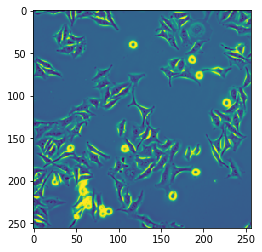

In [16]:
plot_map(test_x[0])

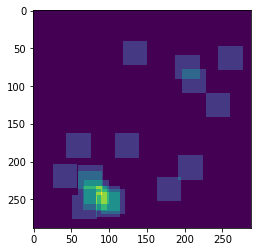

In [17]:
plot_map(test_y[0])

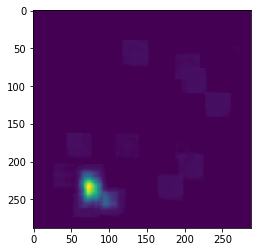

In [20]:
plot_map(pred[0])

Train from scratch.

In [21]:
TRAIN = True
batch_size = 4
epochs = 100

In [22]:
model = build_model(train_conv=TRAIN)
bestcheck = ModelCheckpoint(filepath="best-models-3/model-best-ours521-div-from-scratch.h5", verbose=1, save_weights_only=True, save_best_only=True)
every10check = ModelCheckpoint(filepath="models-3/model-ours521-div-from-scratch-cp.{epoch:02d}-{val_loss:.2f}.h5", verbose=1, period=10, save_weights_only=True)
tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

hist = model.fit(train_x, train_y, epochs=epochs, initial_epoch=0, batch_size = batch_size,
                 validation_data = (val_x, val_y), 
                 callbacks=[bestcheck, every10check, tbCallBack])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
adapterIadaper_bn1 (BatchNormal (None, 256, 256, 1)  4           input_3[0][0]                    
__________________________________________________________________________________________________
adapterIadapter_conv (Conv2D)   (None, 256, 256, 1)  2           adapterIadaper_bn1[0][0]         
__________________________________________________________________________________________________
add_11 (Add)                    (None, 256, 256, 1)  0           adapterIadapter_conv[0][0]       
                                                                 input_3[0][0]                    
__________

Train on 67 samples, validate on 8 samples
Epoch 1/100
67/67 [==============================] - 18s 264ms/step - loss: 0.5036 - acc: 0.7500 - val_loss: 10.2235 - val_acc: 0.4686

Epoch 00001: val_loss improved from inf to 10.22350, saving model to best-models-3/model-best-ours521-div-from-scratch.h5
Epoch 2/100
67/67 [==============================] - 12s 176ms/step - loss: 0.3245 - acc: 0.8468 - val_loss: 2.7326 - val_acc: 0.5409

Epoch 00002: val_loss improved from 10.22350 to 2.73263, saving model to best-models-3/model-best-ours521-div-from-scratch.h5
Epoch 3/100
67/67 [==============================] - 12s 176ms/step - loss: 0.2773 - acc: 0.8464 - val_loss: 3.3297 - val_acc: 0.6137

Epoch 00003: val_loss did not improve from 2.73263
Epoch 4/100
67/67 [==============================] - 12s 175ms/step - loss: 0.2619 - acc: 0.8498 - val_loss: 0.5546 - val_acc: 0.7883

Epoch 00004: val_loss improved from 2.73263 to 0.55459, saving model to best-models-3/model-best-ours521-div-from-scr

Epoch 39/100
67/67 [==============================] - 12s 175ms/step - loss: 0.0788 - acc: 0.9475 - val_loss: 0.1766 - val_acc: 0.8705

Epoch 00039: val_loss did not improve from 0.09356
Epoch 40/100
67/67 [==============================] - 12s 176ms/step - loss: 0.0820 - acc: 0.9443 - val_loss: 0.1751 - val_acc: 0.8783

Epoch 00040: val_loss did not improve from 0.09356

Epoch 00040: saving model to models-3/model-ours521-div-from-scratch-cp.40-0.18.h5
Epoch 41/100
67/67 [==============================] - 12s 176ms/step - loss: 0.0755 - acc: 0.9488 - val_loss: 0.0862 - val_acc: 0.9363

Epoch 00041: val_loss improved from 0.09356 to 0.08624, saving model to best-models-3/model-best-ours521-div-from-scratch.h5
Epoch 42/100
67/67 [==============================] - 12s 175ms/step - loss: 0.0843 - acc: 0.9443 - val_loss: 0.0971 - val_acc: 0.9214

Epoch 00042: val_loss did not improve from 0.08624
Epoch 43/100
67/67 [==============================] - 12s 176ms/step - loss: 0.0851 - acc: 0.9


Epoch 00076: val_loss improved from 0.04514 to 0.04474, saving model to best-models-3/model-best-ours521-div-from-scratch.h5
Epoch 77/100
67/67 [==============================] - 12s 174ms/step - loss: 0.0702 - acc: 0.9575 - val_loss: 0.0454 - val_acc: 0.9659

Epoch 00077: val_loss did not improve from 0.04474
Epoch 78/100
67/67 [==============================] - 12s 174ms/step - loss: 0.0668 - acc: 0.9637 - val_loss: 0.0490 - val_acc: 0.9627

Epoch 00078: val_loss did not improve from 0.04474
Epoch 79/100
67/67 [==============================] - 12s 174ms/step - loss: 0.0732 - acc: 0.9562 - val_loss: 0.0548 - val_acc: 0.9578

Epoch 00079: val_loss did not improve from 0.04474
Epoch 80/100
67/67 [==============================] - 12s 174ms/step - loss: 0.0491 - acc: 0.9734 - val_loss: 0.0981 - val_acc: 0.9113

Epoch 00080: val_loss did not improve from 0.04474

Epoch 00080: saving model to models-3/model-ours521-div-from-scratch-cp.80-0.10.h5
Epoch 81/100
67/67 [======================

Load the best model.

In [23]:
TRAIN = False
model = build_model(train_conv=TRAIN)
model.load_weights("best-models-3/model-best-ours521-div-from-scratch.h5", by_name=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
adapterIadaper_bn1 (BatchNormal (None, 256, 256, 1)  4           input_4[0][0]                    
__________________________________________________________________________________________________
adapterIadapter_conv (Conv2D)   (None, 256, 256, 1)  2           adapterIadaper_bn1[0][0]         
__________________________________________________________________________________________________
add_16 (Add)                    (None, 256, 256, 1)  0           adapterIadapter_conv[0][0]       
                                                                 input_4[0][0]                    
__________

Test.

In [24]:
pred = model.predict(test_x, batch_size=1)
preds = sum_count_map(pred)
tests = np.concatenate(test_c)
print("Test MSE:", np.mean((preds-tests)**2))
print("Test MAE:", np.mean(np.abs(preds-tests)))
print("Test std:", np.mean(np.std(preds-tests)))

Test MSE: 4.907646320596655
Test MAE: 1.867396354675293
Test std: 1.957453229723333


In [25]:
preds

array([19.66016197,  6.58813715, 18.8873806 ,  4.7150588 ])

In [26]:
tests

array([18., 10., 19.,  7.])

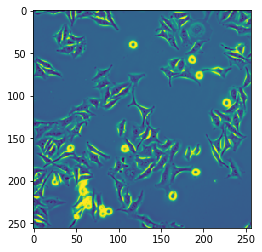

In [27]:
plot_map(test_x[0])

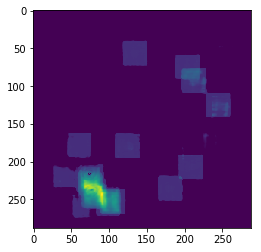

In [28]:
plot_map(pred[0])